In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!python -m pip install ipykernel && python -m ipykernel install --user --name sugar

In [3]:
#!conda env export > environment.yml

<center>
<h1> SuGaR: Surface-Aligned Gaussian Splatting for Efficient 3D Mesh Reconstruction 
    <br>and High-Quality Mesh Rendering</h1>
Antoine Guédon and Vincent Lepetit

In [4]:
import copy
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    AmbientLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
)
from pytorch3d.renderer.blending import BlendParams
import trimesh
import torch

from sugar_scene.gs_model import GaussianSplattingWrapper
from sugar_scene.sugar_model import SuGaR, load_refined_model
from sugar_utils.spherical_harmonics import SH2RGB

import sys
sys.path.insert(0, os.path.abspath(".."))
from evaluate import evaluate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using original 3DGS rasterizer from Inria.


In [5]:
numGPU = 0
torch.cuda.set_device(numGPU)

# Load data and vanilla Gaussian Splatting

In [6]:
# ========== Loading parameters ==========
use_eval_split = False
n_skip_images_for_eval_split = 8

iteration_to_load = 7000
# iteration_to_load = 30_000

load_gt_images = False
use_custom_bbox = False

Choose a data directory (the directory that contains the images subdirectory).

In [7]:
# Example

data_path = "../data"
output_path = "output"

name = "test_data_demogorgon"

source_path = os.path.join(data_path, name + "/")

Choose a corresponding vanilla Gaussian Splatting checkpoint directory.

In [8]:
gs_checkpoint_path = os.path.join(output_path, "vanilla", name + "/") 

Load data and 3DGS checkpoint.

In [9]:
# Load Gaussian Splatting checkpoint 
print(f"\nLoading config {gs_checkpoint_path}...")
if use_eval_split:
    print("Performing train/eval split...")

gs_model = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_checkpoint_path,
    iteration_to_load=iteration_to_load,
    load_gt_images=load_gt_images,
    eval_split=use_eval_split,
    eval_split_interval=n_skip_images_for_eval_split,
)

cameras = gs_model.training_cameras

print(f'{len(cameras)} training images detected.')
print(f'The model has been trained for {iteration_to_load} steps.')
print(len(gs_model.gaussians._xyz) / 1e6, "M gaussians detected.")


Loading config output/vanilla/test_data_demogorgon/...
Found image extension .JPG
87 training images detected.
The model has been trained for 7000 steps.
0.364289 M gaussians detected.


In [10]:
def show(image, title, plot_ratio=2.0):
    plt.figure(figsize=(10 * plot_ratio, 10 * plot_ratio))
    plt.axis("off")
    plt.title(title)
    plt.imshow(image)

Image name: IMG_5520


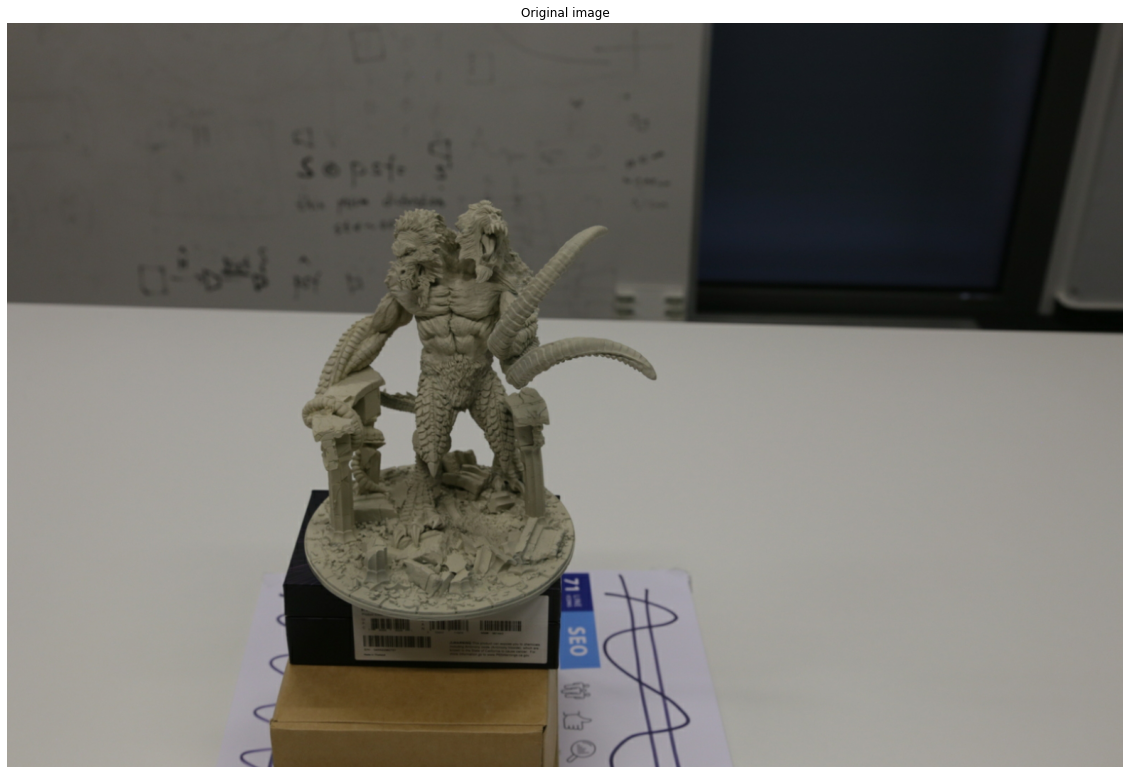

In [11]:
cam_idx = 0
image_name = gs_model.cam_list[cam_idx].image_name
print("Image name:", cameras.gs_cameras[cam_idx].image_name)

original_image = Image.open(os.path.join(source_path, "images", image_name + ".JPG"))
show(original_image, "Original image")

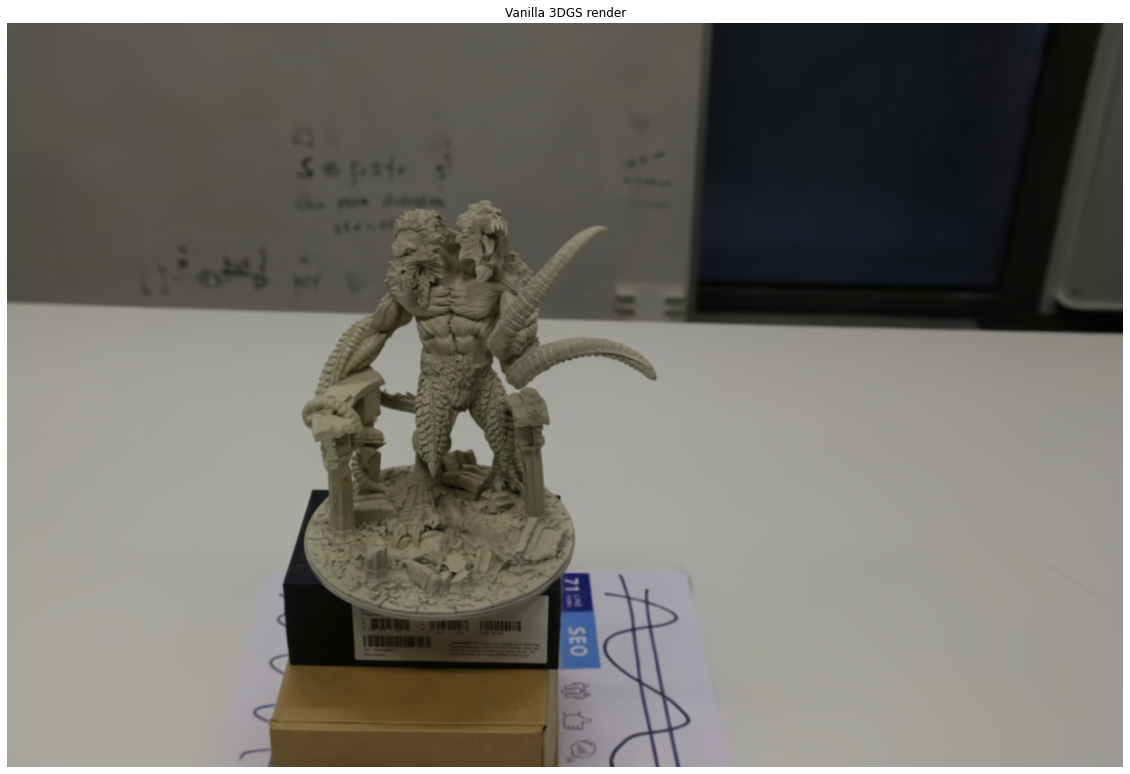

In [12]:
with torch.no_grad():
    gs_image = gs_model.render_image(nerf_cameras=cameras, camera_indices=cam_idx)
    gs_image = gs_image.clamp(min=0, max=1)
    gs_image = gs_image.cpu().numpy()

show(gs_image, "Vanilla 3DGS render")

# Coarse SuGaR model

Choose a corresponding coarse SuGaR checkpoint directory (located in `coarse/<your scene>`)

In [13]:
coarse_sugar_folder = os.path.join(output_path, "coarse", name + "/")
coarse_sugar_folder = os.path.join(coarse_sugar_folder, os.listdir(coarse_sugar_folder)[0])
coarse_sugar_folder

'output/coarse/test_data_demogorgon/sugarcoarse_3Dgs7000_densityestim02_sdfnorm02'

Choose a coarse iteration to load.

In [14]:
coarse_iteration_to_load = 15_000

Load the coarse SuGaR checkpoint.

In [15]:
coarse_mesh_path = os.path.join(output_path, "coarse_mesh", name)
coarse_mesh_path = os.path.join(coarse_mesh_path, os.listdir(coarse_mesh_path)[0])
coarse_mesh = o3d.io.read_triangle_mesh(coarse_mesh_path)
coarse_mesh

TriangleMesh with 774678 points and 1489177 triangles.

In [16]:
gt_mesh = o3d.io.read_triangle_mesh(os.path.join(source_path, "gt_mesh.ply"))
gt_mesh

TriangleMesh with 1569618 points and 3139272 triangles.

In [17]:
evaluate(coarse_mesh, gt_mesh, output_dir=os.path.join(output_path, "coarse"))

Use Open3D coordinate system
Transform reconstructed mesh with:
[[ 0.99690966 -0.07557869  0.02126221  0.17991995]
 [-0.0564357  -0.50125159  0.86347171 -0.36422869]
 [-0.0545966  -0.86199765 -0.50394905 -0.50027813]
 [ 0.          0.          0.          1.        ]]
Scale reconstructed mesh by: 177.1121505336849
Normalized Chamfer distance (vertex): 2.82 mm
Normalized Chamfer distance (poisson): 2.64 mm
Save final mesh to output/coarse/coarse_ncdv=2.82_ncdp=2.64.ply


{'ncd_v': 2.821105833799246, 'ncd_p': 2.641119940393301}

# Refined SuGaR model

Choose a corresponding refined SuGaR checkpoint directory (located in `refined/<your scene>`)

In [18]:
refined_sugar_folder = os.path.join(output_path, "refined", name + "/")
refined_sugar_folder = os.path.join(refined_sugar_folder, os.listdir(refined_sugar_folder)[0])
refined_sugar_folder

'output/refined/test_data_demogorgon/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1'

Choose a refinement iteration to load.

In [19]:
refined_iteration_to_load = 15_000

Load the refined SuGaR checkpoint.

In [20]:
refined_sugar_path = os.path.join(refined_sugar_folder, f"{refined_iteration_to_load}.pt")
print(f"\nLoading config {refined_sugar_path}...")

refined_sugar = load_refined_model(refined_sugar_path, gs_model, headless=True)
refined_sugar.eval()


Loading config output/refined/test_data_demogorgon/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1/15000.pt...
Loading refined model...
1489177 faces detected.
1489177 gaussians detected.
1 gaussians per surface triangle detected.
SuGaR headless: True
Binding radiance cloud to surface mesh...


SuGaR()

Render an image.

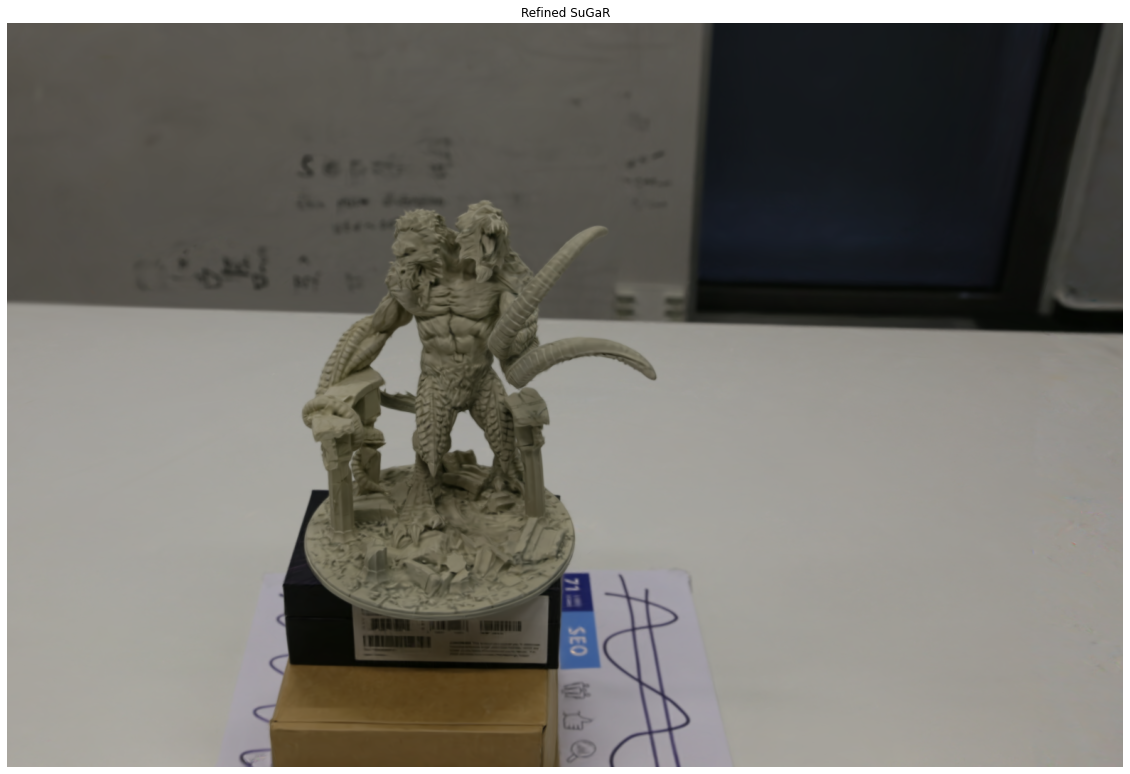

In [21]:
refined_sugar.adapt_to_cameras(cameras)

with torch.no_grad():
    sugar_image = refined_sugar.render_image_gaussian_rasterizer(
        nerf_cameras=cameras, 
        camera_indices=cam_idx,
        sh_deg=gs_model.gaussians.active_sh_degree,
        compute_color_in_rasterizer=True,
    )
    sugar_image = sugar_image.nan_to_num()
    sugar_image = sugar_image.clamp(min=0, max=1)
    sugar_image = sugar_image.cpu().numpy()

show(sugar_image, "Refined SuGaR")

In [22]:
refined_mesh_path = os.path.join(output_path, "refined_mesh", name, refined_sugar_path.split('/')[-2].split('.')[0] + '.obj')
print(f"Loading refined mesh from {refined_mesh_path}, this could take a minute...")
refined_mesh = load_objs_as_meshes([refined_mesh_path]).to(gs_model.device)
print(f"Loaded mesh with {len(refined_mesh.verts_list()[0])} vertices and {len(refined_mesh.faces_list()[0])} faces.")

Loading refined mesh from output/refined_mesh/test_data_demogorgon/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1.obj, this could take a minute...
Loaded mesh with 774678 vertices and 1489177 faces.


Rendering image 0
Image ID: IMG_5520


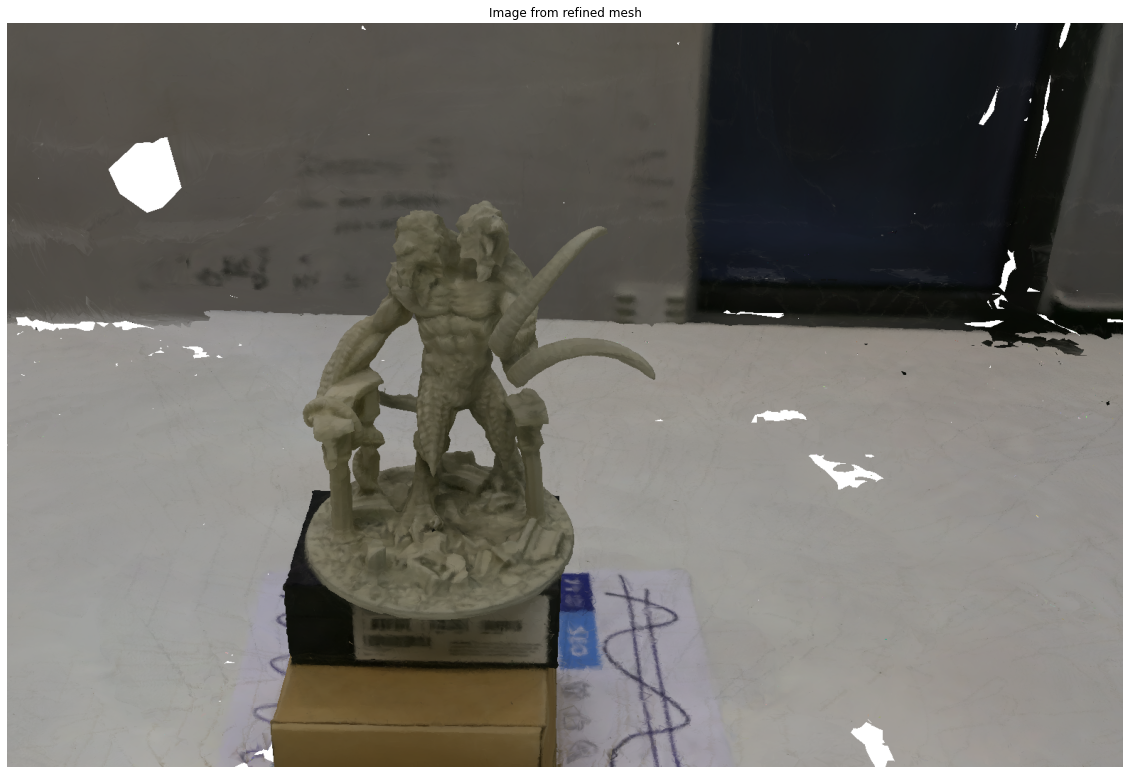

In [23]:
mesh_raster_settings = RasterizationSettings(
    image_size=(refined_sugar.image_height, refined_sugar.image_width),
    blur_radius=0.0, 
    faces_per_pixel=1,
)
lights = AmbientLights(device=gs_model.device)
rasterizer = MeshRasterizer(
    cameras=cameras.p3d_cameras[cam_idx], 
    raster_settings=mesh_raster_settings,
)
renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=SoftPhongShader(
        device=refined_sugar.device, 
        cameras=cameras.p3d_cameras[cam_idx],
        lights=lights,
        blend_params=BlendParams(background_color=(1.0, 1.0, 1.0)),
    )
)

with torch.no_grad():    
    print("Rendering image", cam_idx)
    print("Image ID:", cameras.gs_cameras[cam_idx].image_name)
    
    p3d_cameras = cameras.p3d_cameras[cam_idx]
    image_from_refined_mesh = renderer(refined_mesh, cameras=p3d_cameras)[0, ..., :3]
    image_from_refined_mesh = image_from_refined_mesh.cpu().numpy()

show(image_from_refined_mesh, "Image from refined mesh")

In [24]:
refined_mesh = o3d.io.read_triangle_mesh(refined_mesh_path)
evaluate(refined_mesh, gt_mesh, output_dir=os.path.join(output_path, "refined"))

Use Open3D coordinate system
Transform reconstructed mesh with:
[[ 0.99690966 -0.07557869  0.02126221  0.17991995]
 [-0.0564357  -0.50125159  0.86347171 -0.36422869]
 [-0.0545966  -0.86199765 -0.50394905 -0.50027813]
 [ 0.          0.          0.          1.        ]]
Scale reconstructed mesh by: 177.1121505336849
[Open3D WARNING] [SelectByIndex] This mesh contains triangle uvs that are not handled in this function
Normalized Chamfer distance (vertex): 2.46 mm
Normalized Chamfer distance (poisson): 2.31 mm
Save final mesh to output/refined/refined_ncdv=2.46_ncdp=2.31.ply


{'ncd_v': 2.4587848104413053, 'ncd_p': 2.3082867077501925}